# SVI with 2D Gaussian Process Prior

`**Warning**`: This notebook is less refined than the previous notebooks. It's an older book that I'm adding as an additional resource to users and has not been checked for accuracy.

Besides that, there are two issues with this code:

1. During the SVI, the `PRNGKey` used to sample derivatives does not change. This can be fixed by manually adding the `PRNGKey` as we did in the previous notebook. 
2. After the fit, I obtain GP samples from the `guide` tracking the inducing point values of the GP. The sampler code used to do this is extremely inefficient. This can be sped-up with `jit` or making a vectorized sampler like the `extrapolate_gp` function in the `utils/custom.py`

These changes are easy to implement if you understand the previous notebooks and the first two notebooks in the [sparse-tinygp][1] repo. I am not implementing these fixes because this will be done in another repo that I plan to publish in the future. This repo would contain the results from the project that required me to learn GPs in the first place.

<!-- ### References -->

[1]: <https://github.com/edwarddramirez/sparse-tinygp> "sparse-tinygp"

In [1]:
# necessary packages
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
import numpyro # for inference and probabilistic programming
import tinygp  # for Gaussian process regression
from tinygp import GaussianProcess, kernels
import numpyro.distributions as dist
from tinygp import transforms
import matplotlib as mpl

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 1.0, 'True Rate')

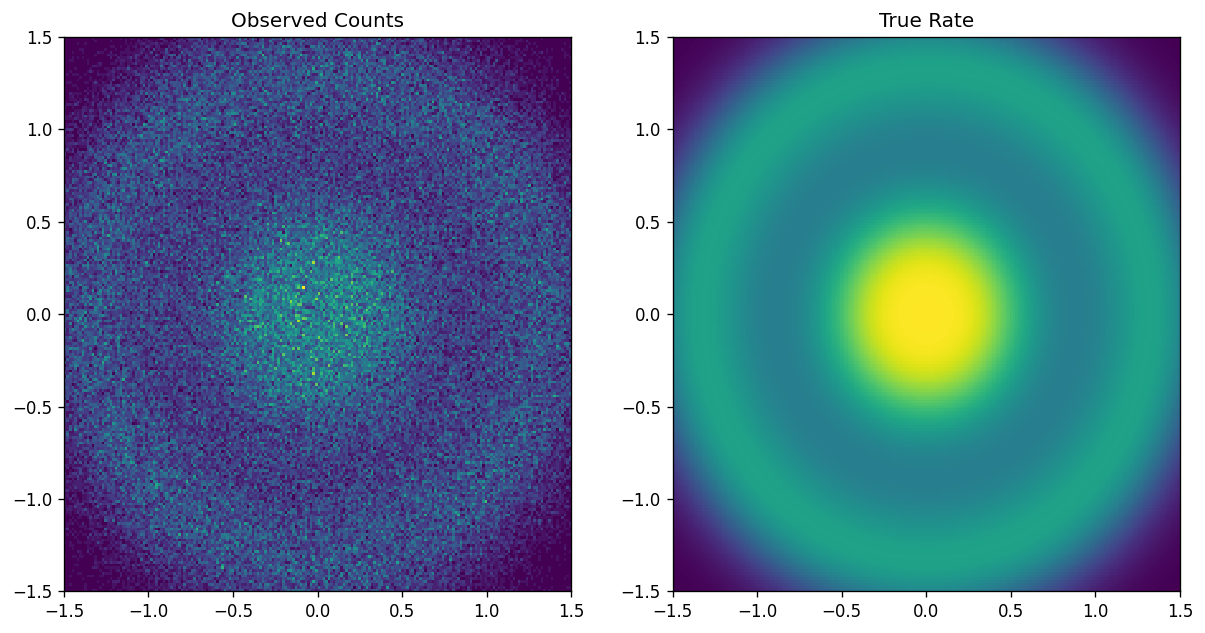

In [3]:
# plot the true function
x1_plt = jnp.linspace(-1.5, 1.5, 201)
x2_plt = jnp.linspace(-1.5, 1.5, 201)
x1_c = 0.5 * (x1_plt[1:] + x1_plt[:-1]) ; x2_c = 0.5 * (x2_plt[1:] + x2_plt[:-1])
x1, x2 = jnp.meshgrid(x1_c, x2_c)
x = jnp.stack([x1, x2], axis=-1)
x_mag = jnp.linalg.norm(x, axis = -1)
log_rate = -0.6 * x_mag**2. * jnp.abs(1.5 + jnp.cos(8. * x_mag**(0.5)))
rate = 10 * jnp.exp(log_rate)
y = rate.astype(np.float32)

# add poisson noise
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y) 
y_obs = y_obs.astype(np.float32)

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)
ax.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis')
ax.set_title('Observed Counts')

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')

Text(0, 0.5, 'y')

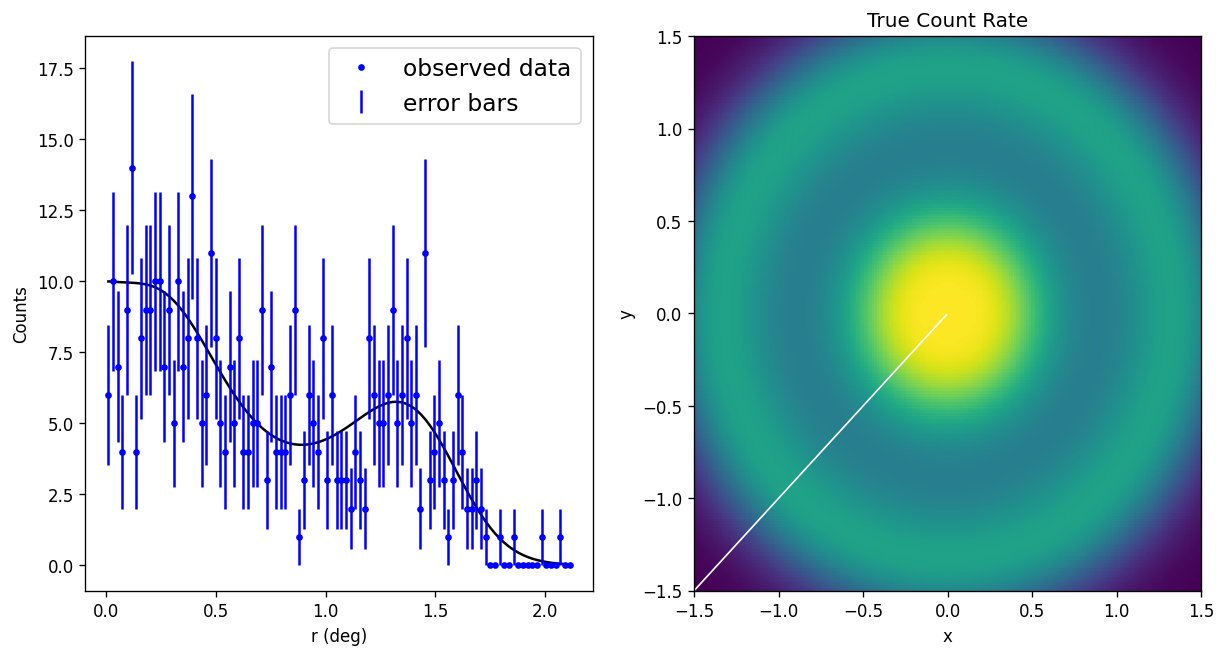

In [4]:
# Plot fit curves on a slice of x-values

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=np.max(y)))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

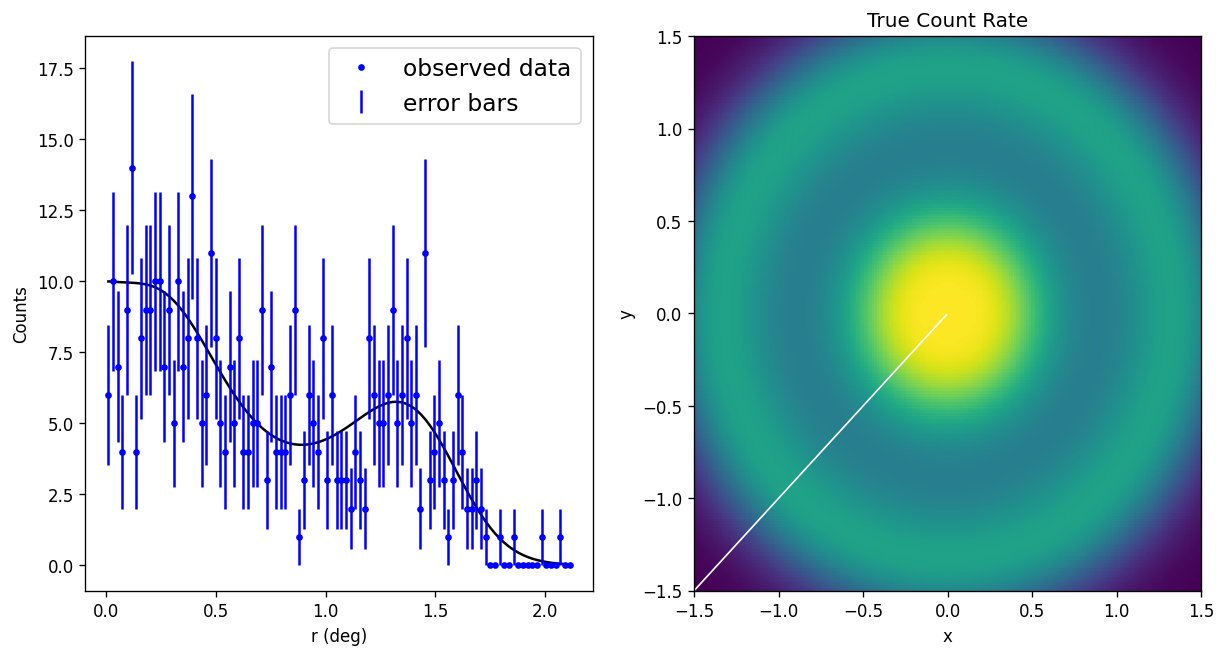

In [5]:
# Plot fit curves on a slice of x-values

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=np.max(y)))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [6]:
# for 2D fitting, need to reshape data into 1D arrays
# KEY: shape must be of the form (N_data, ) NOT (N_data) or (N_data, 1))   
Nx, Ny = x.shape[:-1]
x_f = x.reshape((Nx*Ny,2))
y_obs_f = y_obs.reshape((Nx*Ny,))

In [7]:
class DerivativeKernel(kernels.Kernel):
    def __init__(self, kernel):
        self.kernel = kernel
    def evaluate(self, X1, X2):
        x1, y1, d1x, d1y = X1
        x2, y2, d2x, d2y = X2
        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(jnp.array([x1,y1]), jnp.array([x2,y2]))
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(lambda x2_: self.kernel.evaluate(jnp.array([x1,y1]),jnp.array([x2_,y2])))(x2)
        dK_dx1 = jax.grad(lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2,y2])))(x1)
        d2K_dx1dx2 = (jax.grad( lambda x2_: 
            ( jax.grad( lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2_,y2]))) )(x1) 
            ) )(x2) 
        
        dK_dy2 = jax.grad(lambda y2_: self.kernel.evaluate(jnp.array([x1,y1]),jnp.array([x2,y2_])))(y2)
        dK_dy1 = jax.grad(lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2,y2])))(y1)
        d2K_dy1dy2 = (jax.grad( lambda y2_: 
            ( jax.grad( lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2,y2_]))) )(y1) 
            ) )(y2) 
        
        d2K_dx1dy2 = (jax.grad( lambda y2_: 
            ( jax.grad( lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2,y2_]))) )(x1) 
            ) )(y2) 
        d2K_dy1dx2 = (jax.grad( lambda x2_: 
            ( jax.grad( lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2_,y2]))) )(y1) 
            ) )(x2) 
        
        return jnp.where(d1x, 
                         jnp.where(d2x, d2K_dx1dx2, jnp.where(d2y, d2K_dx1dy2, dK_dx1)),
                         jnp.where(d1y, jnp.where(d2x, d2K_dy1dx2, jnp.where(d2y, d2K_dy1dy2, dK_dy1)), 
                                   jnp.where(d2x, dK_dx2, jnp.where(d2y, dK_dy2, K)))
                                   )

In [8]:
jax.config.update("jax_enable_x64", False)
jax.config.update("jax_debug_nans", False)

Nx = x_f.shape[0]
Nu = 10*10
Np = 100
Nsub = 100
N_list = [Nx, Nu, Np, Nsub]

sNu = jnp.sqrt(Nu).astype(int)
t = jnp.linspace(-2,2,sNu)
t1 = jnp.concatenate([t for i in range(sNu)])
t2 = jnp.array(jnp.concatenate([t[n] * jnp.ones(sNu) for n in range(sNu)]))
initial_u = [t1,t2]
print(t1.shape)
print(t2.shape)

def model(x, y=None, N_list=None, initial_u=None):
    # load list of important numbers
    Nx, Nu, Np, Nsub = N_list

    # generate kernel parameters
    amp = numpyro.param('amp', jnp.ones(()), constraint=dist.constraints.positive)
    scale = numpyro.param('scale', jnp.ones(()), constraint=dist.constraints.positive)

    t1, t2 = initial_u
    
    # generate induced points
    txu = numpyro.param(
        "txu", t1
    )
    xu = -1.5 + 3. * jax.nn.sigmoid(txu)

    tyu = numpyro.param(
        "tyu", t2
    )
    yu = -1.5 + 3. * jax.nn.sigmoid(tyu)

    xu_f = jnp.vstack([xu.T,yu.T]).T
    
    # generate derivative points and augment data
    xp_f = -1.5 + 3. * jax.random.uniform(jax.random.PRNGKey(np.random.randint(low=0, high=10000000)), shape = (Np,2))
    x3 = jnp.concatenate([xp_f,xp_f,xp_f])
    d3x = jnp.concatenate([jnp.zeros(Np),jnp.ones(Np),jnp.zeros(Np)])
    d3y = jnp.concatenate([jnp.zeros(Np),jnp.zeros(Np),jnp.ones(Np)])
    xp_aug = jnp.vstack([x3.T,d3x.T,d3y.T]).T

    # augment the induced points
    dxu = jnp.zeros(Nu)
    dyu = jnp.zeros(Nu)
    xu_aug = jnp.vstack([xu_f.T,dxu.T,dyu.T]).T

    # load joint kernel from the original function kernel
    base_kernel = amp**2. * transforms.Linear(scale, kernels.ExpSquared())
    kernel = DerivativeKernel(base_kernel)
    gp_u = GaussianProcess(kernel, xu_aug, diag=1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())

    # load kernel and sample from GP
    with numpyro.plate('observe_data', size=Nx, subsample_size=Nsub) as ind:
        # augment data
        x_sub = x[ind]
        dx = jnp.zeros(Nsub)
        dy = jnp.zeros(Nsub)
        x_sub_aug = jnp.vstack([x_sub.T,dx.T,dy.T]).T

        _, gp_x = gp_u.condition(log_rate_u, x_sub_aug, diag=1e-3)
        log_rate = gp_x.sample(jax.random.PRNGKey(np.random.randint(low=0, high=10000000)))

        # load function values and compute log likelihood
        numpyro.sample("obs", dist.Poisson(jnp.exp(log_rate)), obs=y[ind]) 

        # sample log_rate_deriv from GP conditioned on log_rate
        _, gp_cond = gp_x.condition(log_rate, xp_aug) # condition GP on log_rate and sample derivatives at x_aug[Nx:]
        log_rate_xp_aug = gp_cond.sample(jax.random.PRNGKey(np.random.randint(low=0, high=10000000))) # log_rate_deriv
        log_rate_xp = log_rate_xp_aug[:Np]
        log_rate_xp_px = log_rate_xp_aug[Np:(2*Np)]
        log_rate_xp_py = log_rate_xp_aug[(2*Np):]
        
        rate_xp = jnp.exp(log_rate_xp) 
        rate_xp_px = rate_xp * log_rate_xp_px # rate_deriv_x
        rate_xp_py = rate_xp * log_rate_xp_py # rate_deriv_y

        x_mag = jnp.sqrt(jnp.sum(xp_f**2., axis=1))
        x_hat = xp_f / x_mag[:,None]
        rate_p = rate_xp_px * x_hat[:,0] + rate_xp_py * x_hat[:,1]
        numpyro.factor("constraint", -10. * jnp.sum(jnp.where(rate_p > 0, rate_p, 0.)))

# guide of posterior distribution of log_rate and log_rate_deriv
guide = numpyro.infer.autoguide.AutoMultivariateNormal(model)

# run SVI
optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(5573), 12000, x_f, y=y_obs_f, N_list=N_list,initial_u=initial_u, progress_bar=True)

(100,)
(100,)


100%|██████████| 12000/12000 [05:35<00:00, 35.80it/s, init loss: 248603440.0000, avg. loss [11401-12000]: 89816.1953]


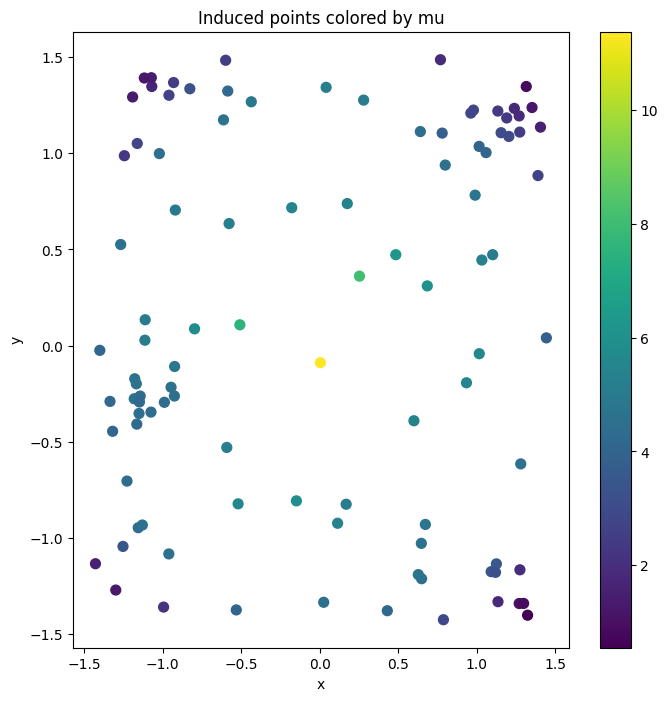

In [9]:
xu = -1.5 + 3. * jax.nn.sigmoid(results.params['txu'])
yu = -1.5 + 3. * jax.nn.sigmoid(results.params['tyu'])
mu = results.params["auto_loc"]

# make a scatter plot of the induced points colored by mu
plt.figure(figsize=(8,8))
plt.scatter(xu, yu, c=jnp.exp(mu), s=50, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Induced points colored by mu')
plt.show()

In [10]:
import timeit

t1 = timeit.default_timer()

num_samples = 100
rng_key, key = jax.random.split(jax.random.PRNGKey(19))
svi_samples = svi.guide.sample_posterior(
    rng_key=rng_key,
    params=results.params,
    sample_shape=(num_samples,)
)

t2 = timeit.default_timer()

print(t2 - t1)

0.5350188268348575


In [11]:
# define grid on lowres data

res_scale = 2

Nx1 = x1_c.shape[0]
Nx2 = x2_c.shape[0]

c1_plt = jnp.linspace(-1.5, 1.5, int(Nx1 / res_scale) + 1)
c2_plt = jnp.linspace(-1.5, 1.5, int(Nx2 / res_scale) + 1)
c1_c = 0.5 * (c1_plt[1:] + c1_plt[:-1]) ; c2_c = 0.5 * (c2_plt[1:] + c2_plt[:-1])
c1, c2 = jnp.meshgrid(c1_c, c2_c)
c = jnp.stack([c1, c2], axis=-1)
c_f = c.reshape((c.shape[0]*c.shape[1],2))

In [12]:
import timeit as timeit

# fill in the gaps with conditioned GPs
amp = results.params['amp']
scale = results.params['scale']
kernel = amp**2. * transforms.Linear(scale, kernels.ExpSquared())
xu = -1.5 + 3. * jax.nn.sigmoid(results.params['txu'])
yu = -1.5 + 3. * jax.nn.sigmoid(results.params['tyu'])
xu_f = jnp.vstack([xu.T,yu.T]).T
gp_u = GaussianProcess(kernel, xu_f, diag=1e-3)

samples = svi_samples['log_rate_u']

@jax.jit
def create_sample_int_(n,x,samples,key):
    log_rate_sub = samples.at[n].get()
    _, gp_int = gp_u.condition(log_rate_sub, x, diag=1e-3)
    # return gp_int.mean
    log_rate_int = gp_int.sample(jax.random.PRNGKey(key))
    return log_rate_int

test_sample = create_sample_int_(0,c_f,samples,19)

Text(0.5, 1.0, 'Counts')

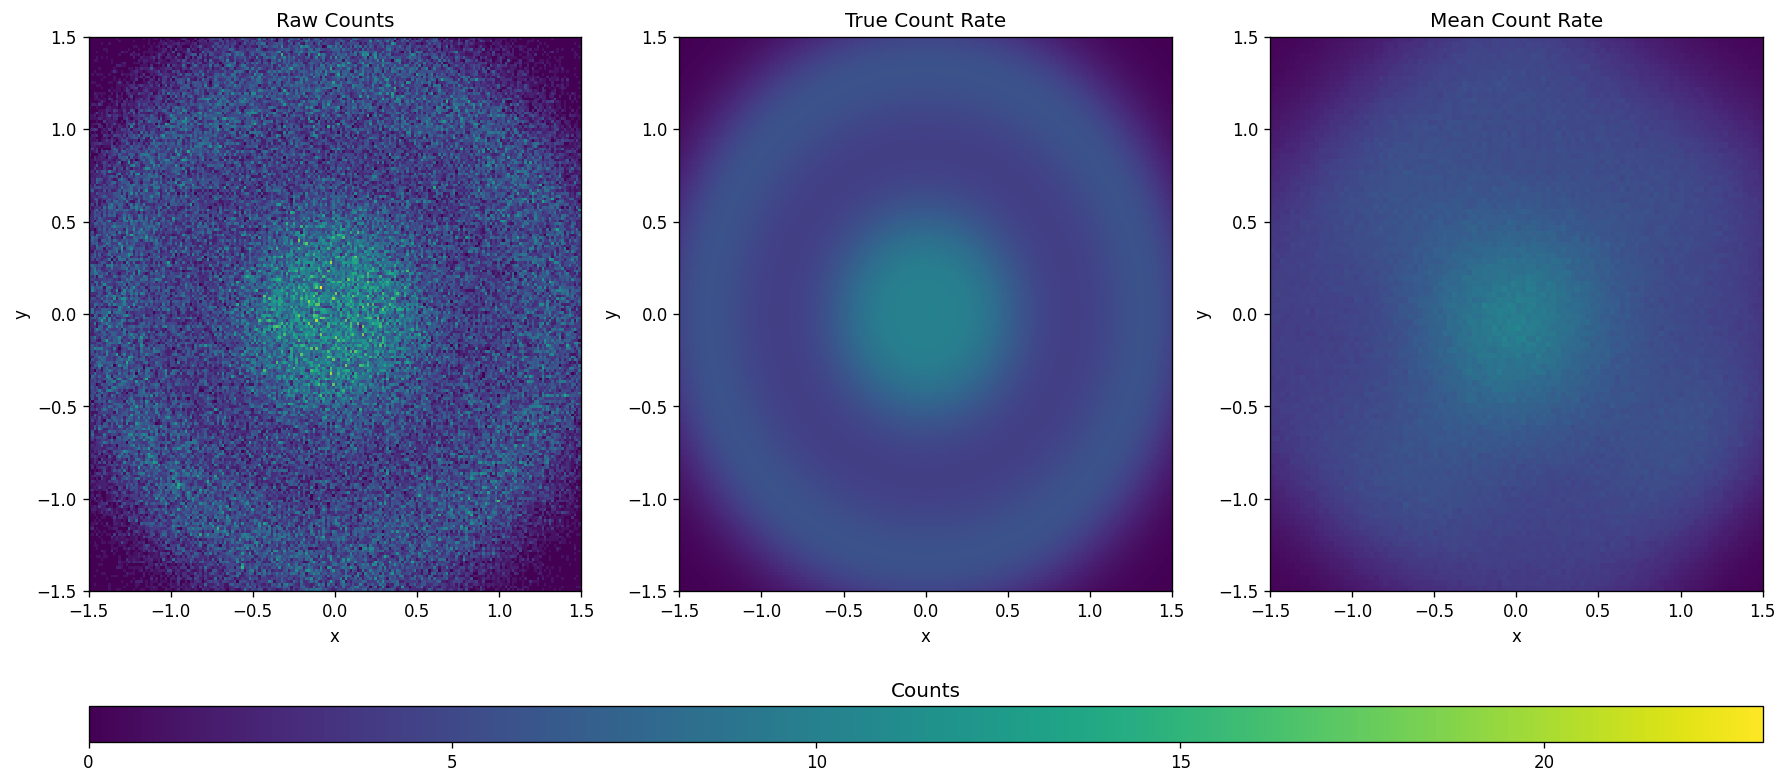

In [13]:
test_sample_r = test_sample.reshape((c.shape[0],c.shape[1]))

# plot raw count map, true rate map, and mean rate map from posterior of log_rate

import matplotlib as mpl

vmax = np.max([np.max(y_obs), np.max(y), np.max(jnp.exp(test_sample_r))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(c1_plt, c2_plt, jnp.exp(test_sample_r), cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

In [14]:
def create_samples_int_(x,samples,keys_ind):
    for n in range(samples.shape[0]):
        key = keys_ind[n]
        if n == 0:
            samples_int = create_sample_int_(n,x,samples,key)
        else:
            print(n)
            samples_int = np.vstack((samples_int, create_sample_int_(n,x,samples,key)))
    return samples_int

keys_ind = np.random.randint(low=0,high=1000000,size=samples.shape[0])
print(keys_ind.shape)
t1 = timeit.default_timer()

samples_int = create_samples_int_(c_f,samples,keys_ind)


t2 = timeit.default_timer()
print(t2 - t1)

(100,)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
20.47515287529677


In [15]:
samples_r = samples_int.reshape(num_samples,c.shape[0],c.shape[1])

Text(0.5, 1.0, 'Counts')

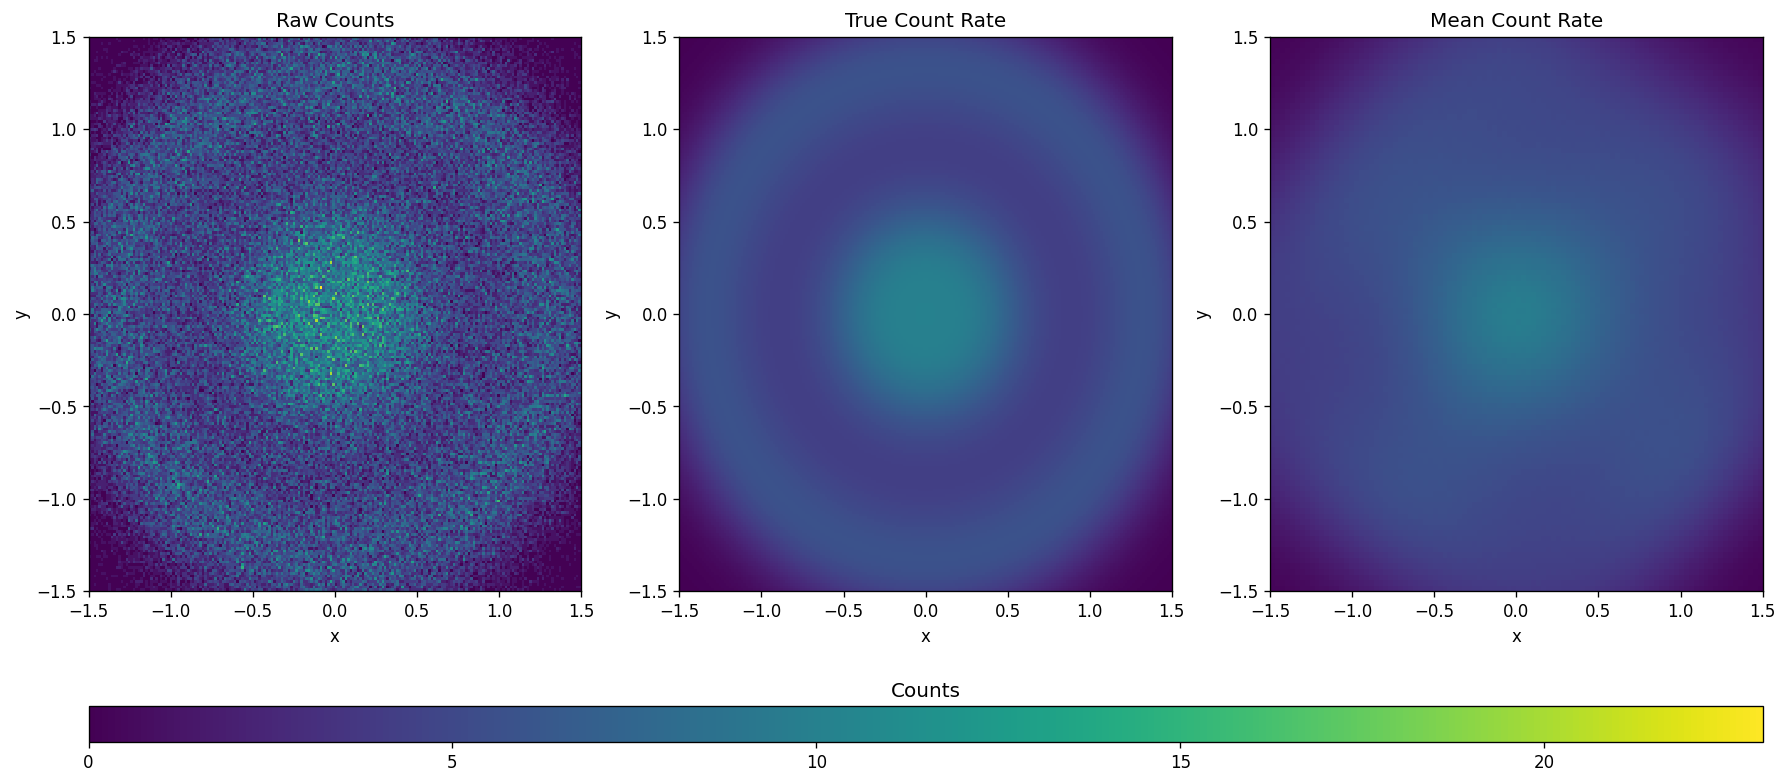

In [16]:
q = np.percentile(samples_r, [5,50,95], axis = 0)

# plot raw count map, true rate map, and mean rate map from posterior of log_rate

import matplotlib as mpl

vmax = np.max([np.max(y_obs), np.max(y), np.max(np.exp(q[1]))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(c1_plt, c2_plt, jnp.exp(q[1]), cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

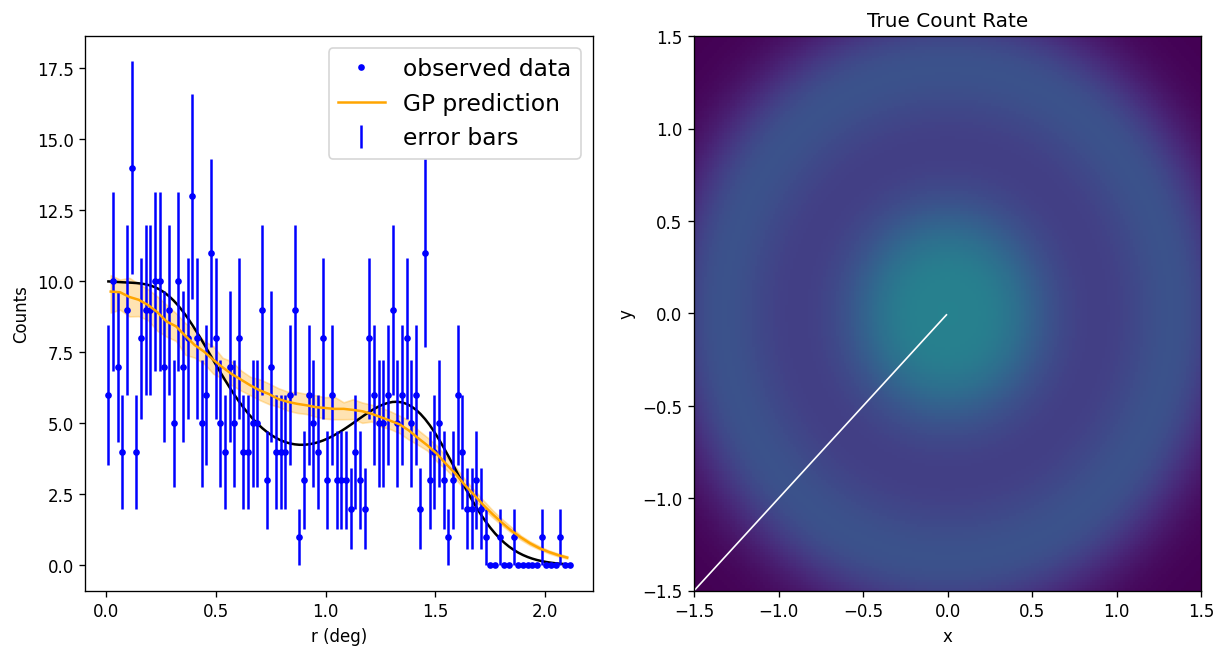

In [17]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)

Ncx = len(c1_c)
ncy = np.arange(0,int(Ncx/2),1)
rc = np.linalg.norm(c[ncy,ncy,:], axis = -1)


ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(rc, np.exp(q[1])[ncy,ncy], c = 'orange', label = 'GP prediction')
ax.fill_between(rc, np.exp(q[0])[ncy,ncy], np.exp(q[2])[ncy,ncy], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')